# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data](#Data)
  * [Loading](#Loading)
  * [Preprocessing](#Preprocessing)
* [Feature extraction](#Feature-extraction)
* [Setup](#Setup)
* [Test harness](#Test-harness)
* [Results](#Results)
* [Discussion](#Discussion)

## Introduction

In this notebook, the samples of short and long duration are merged into a single set to facilitate comparison of padded vs. ragged data. The hope is that the effects of padding will be most noticeable when the amount of padding is greatest.

FRILL features are extracted and fit with a stacking classifier composed of models that showed promise in previous explorations. A test harness is prepared and the results for ragged and padded data are compared.

FRILL embeddings may work better with ragged sequences than padded ones.

### FRILL

Here are two abstracts to introduce the FRILL embedding:

  [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.

  [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers.

## Imports and configuration

In [1]:
# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from torchaudio import load as torchaudio_load

# utility
from collections import namedtuple
from gc import collect as gc_collect
from time import time
from tqdm.notebook import tqdm
import swifter

# Python < 3.9 type hints
from typing import Callable, List, Tuple
from sklearn.base import BaseEstimator

# metrics
from sklearn.metrics import balanced_accuracy_score, f1_score

# cross validator
from sklearn.model_selection import StratifiedGroupKFold

# sklearn classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


# other boosting classifiers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# keras & tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# hide warnings
import warnings

warnings.filterwarnings("ignore")

time: 4.14 s


In [4]:
# Location of pickled dataframes
PICKLED_DF_FOLDER = (
    "../1.0-mic-divide_data_by_duration"
)

# Location where this notebook will output
DATA_OUT_FOLDER = "."

# Location where the FRILL module is stored locally
LOCAL_FRILL = "../../../FRILL/"

# The preprocessed data from the Unified Multilingual Dataset of Emotional Human utterances
WAV_DIRECTORY = "../../../unified_multilingual_dataset_of_emotional_human_utterances/data/preprocessed"

time: 1 ms


## Data

### Loading

The samples of short and long duration are loaded and concatenated in this section.

In [5]:
# read short dataframe
short_df = pd.read_pickle(f"{PICKLED_DF_FOLDER}/short.pkl")
short_df.head(1)

# read long dataframe
long_df = pd.read_pickle(f"{PICKLED_DF_FOLDER}/long.pkl")
long_df.head(1)

,file,duration,source,speaker_id,speaker_gender,emo,valence,lang1,lang2,neg,neu,pos,length
id,,,,,,,,,,,,,
01788,01788+BAUM1+BAUM1.s028+f+hap+1+tur+tr-tr.wav,0.387,BAUM1,BAUM1.s028,f,hap,1,tur,tr-tr,0,0,1,short


,file,duration,source,speaker_id,speaker_gender,emo,valence,lang1,lang2,neg,neu,pos,length
id,,,,,,,,,,,,,
00005,00005+aesdd+aesdd.6+m+ang+-1+ell+el-gr.wav,6.835,aesdd,aesdd.6,m,ang,-1,ell,el-gr,1,0,0,long


time: 61 ms


In [6]:
keep_columns = [
    "file",
    "source",
    "length",
    "speaker_id",
    "speaker_gender",
    "lang1",
    "emo",
    "valence",
    "neg",
    "neu",
    "pos",
]

# combine short and long
df = pd.concat((short_df[keep_columns], long_df[keep_columns]))

# peek
df.head(1)
df.tail(1)
df.info()

,file,source,length,speaker_id,speaker_gender,lang1,emo,valence,neg,neu,pos
id,,,,,,,,,,,
01788,01788+BAUM1+BAUM1.s028+f+hap+1+tur+tr-tr.wav,BAUM1,short,BAUM1.s028,f,tur,hap,1,0,0,1


,file,source,length,speaker_id,speaker_gender,lang1,emo,valence,neg,neu,pos
id,,,,,,,,,,,
83077,83077+ShEMO+ShEMO.F31+f+ang+-1+pes+fa-ir.wav,ShEMO,long,ShEMO.F31,f,pes,ang,-1,1,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 5653 entries, 01788 to 83077
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file            5653 non-null   object
 1   source          5653 non-null   object
 2   length          5653 non-null   object
 3   speaker_id      5653 non-null   object
 4   speaker_gender  5653 non-null   object
 5   lang1           5653 non-null   object
 6   emo             5653 non-null   object
 7   valence         5653 non-null   object
 8   neg             5653 non-null   int32 
 9   neu             5653 non-null   int32 
 10  pos             5653 non-null   int32 
dtypes: int32(3), object(8)
memory usage: 463.7+ KB
time: 46 ms


## Preprocessing

In this section, the combined dataframe is preprocessed before feature extraction. Three data sources contain non-speech samples, so we recode their language attributes first.

In [7]:
df.loc[df.source.isin({"vivae", "LimaCastroScott", "MAV"}), "lang1"] = "___"
df.lang1.value_counts()

eng    4034
pes     555
cmn     332
tur     277
___     137
est     111
ell     100
fra      86
deu      16
arz       5
Name: lang1, dtype: int64

time: 11 ms


Next, we re-encode the data types to more tractable representations.

In [8]:
# non-negative integer labels
# {0: negative/-1, 1: neutral/0, 2: positive/1}
df.valence = np.uint8(df.valence) + 1

# encode as boolean for compactness
for valence in {"neg", "neu", "pos"}:
    df[valence] = np.bool_(df[valence])

# "category" is more compact than object dtype
for categorical in {"source", "length", "speaker_id", "speaker_gender", "lang1", "emo"}:
    df[categorical] = df[categorical].astype("category")

time: 20 ms


We can see that the preprocessing made the data a little more compact.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5653 entries, 01788 to 83077
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            5653 non-null   object  
 1   source          5653 non-null   category
 2   length          5653 non-null   category
 3   speaker_id      5653 non-null   category
 4   speaker_gender  5653 non-null   category
 5   lang1           5653 non-null   category
 6   emo             5653 non-null   category
 7   valence         5653 non-null   uint8   
 8   neg             5653 non-null   bool    
 9   neu             5653 non-null   bool    
 10  pos             5653 non-null   bool    
dtypes: bool(3), category(6), object(1), uint8(1)
memory usage: 171.1+ KB
time: 17 ms


In [10]:
# assign a name and clean up
data = df
del short_df
del long_df
del df
_ = gc_collect()

time: 109 ms


## Feature extraction

Before we can use FRILL, we need to extract the ragged .wav arrays.

Although the original dataset already trimmed leading silences, the precision was based on a 10 ms window. Therefore, there may remain leading zeros where the leading silence does not exceed 10 ms in duration, so we apply an initial trim operation.

In [11]:
data["ragged"] = data.file.apply(
    lambda row: torchaudio_load(filepath=f"{WAV_DIRECTORY}/{row}")[0][0]
)

time: 1min 2s


In [12]:
data = data.drop("file", axis="columns")

time: 0 ns


In [13]:
# trim leading silence (more precise than orginally) and prepare for FRILL extraction
trim_zeros = np.trim_zeros
data["ragged"] = data.ragged.swifter.apply(
    lambda row: np.expand_dims(np.float32(np.trim_zeros(row.numpy())), axis=0)
)

Pandas Apply: 100%|██████████| 5653/5653 [00:00<00:00, 22066.76it/s]

time: 295 ms


In [14]:
# undersample enough to fit everything in local memory
df = data.sample(frac=0.25, random_state=SEED).reset_index(drop=True)

time: 6.01 ms


In [15]:
del PICKLED_DF_FOLDER
del WAV_DIRECTORY
del keep_columns
del trim_zeros
del data

time: 0 ns


In [16]:
# Load FRILL
tf.enable_v2_behavior()
# module = hub.load("https://tfhub.dev/google/nonsemantic-speech-benchmark/frill/1")
module = hub.load(LOCAL_FRILL)

time: 33.1 s


In [17]:
del LOCAL_FRILL
del _
_ = gc_collect()

time: 722 ms


We prepare the ragged FRILL features now, but the padded FRILL features need to be extracted within each cross-validation fold.

In [18]:
# this part is isolated as it is one of the most memory-intensive steps
df["frill"] = df.ragged.swifter.apply(lambda _: module(_)["embedding"][0])

Pandas Apply: 100%|██████████| 1413/1413 [15:31<00:00,  1.52it/s]

time: 16min 40s


In [19]:
_ = gc_collect()

time: 1.72 s


In [20]:
X_frill = pd.DataFrame(df.frill.values.tolist(), dtype=np.float16).set_index(df.index)

time: 27min 33s


In [21]:
_ = gc_collect()

time: 1.81 s


In [22]:
df = df.drop("frill", axis="columns")

time: 999 ms


In [23]:
_ = gc_collect()

time: 1.64 s


## Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of three-fold cross validation such that the results may be easily cast to a `pandas` dataframe.

In [24]:
# classification scenarios
all_cases = {"ternary", "negative", "neutral", "positive", "ternary_ovr"}
metrics = (
    "avg_cv_balanced_accuracy",
    "avg_cv_f1",
    "avg_cv_fit_time",
    "avg_cv_predict_time",
)

# to be cast to pd.DataFrame
results = {key: [] for key in {"model_name", "case", "pad_rag", *metrics}}

time: 2 ms


In [25]:
AvgScores = namedtuple("AvgScores", metrics)


def store_result(
    case: str, model_name: str, pad_rag: str, avg_scores: AvgScores
) -> None:
    "Appends a model's score and fit/predict times to the results."
    for attribute, value in {
        ("model_name", model_name),
        ("case", case),
        ("pad_rag", pad_rag),
        ("avg_cv_balanced_accuracy", avg_scores.avg_cv_balanced_accuracy),
        ("avg_cv_f1", avg_scores.avg_cv_f1),
        ("avg_cv_fit_time", avg_scores.avg_cv_fit_time),
        ("avg_cv_predict_time", avg_scores.avg_cv_predict_time),
    }:
        results[attribute].append(value)

time: 5.01 ms


### Test harness

This section defines a test harness for the models.

The next two cells create a custom feature for stratifying the splits.

In [26]:
strata = df[["speaker_id", "emo", "lang1", "length"]].swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 1413/1413 [00:00<00:00, 52365.34it/s]

time: 71 ms


In [27]:
n_splits = 3
for i in range(n_splits - 1):
    strata.loc[
        strata.isin(
            (strata_counts := strata.value_counts()).loc[strata_counts == i + 1].index
        )
    ] = f"uniques{i}"
strata.value_counts()

uniques0                           323
uniques1                           142
EmoV-DB_sorted.samdisenglong        85
EmoV-DB_sorted.samamuenglong        80
EmoV-DB_sorted.beadisenglong        43
                                  ... 
EmoReact_V_1.0.test2unkenglong       3
EmoReact_V_1.0.train6unkenglong      3
ShEMO.F22sadpeslong                  3
ShEMO.M25neupeslong                  3
MELD.Joeysadenglong                  3
Length: 100, dtype: int64

time: 25 ms


The next few cells pre-calculate some transformations for within-fold padding.

In [28]:
def pad_and_extract(max_ragged: int):
    """Convenience function for padding and extracting FRILL."""

    def inner(row):
        return module(
            np.expand_dims(
                np.pad(
                    _ := np.squeeze(row),
                    (max_ragged - len(_), 0),
                    mode="constant",
                    constant_values=0,
                ),
                axis=0,
            )
        )["embedding"][0].numpy()

    return inner

time: 1 ms


In [29]:
cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

Prepadded = namedtuple("Prepadded", "X_train, X_test")

_apply: pd.DataFrame = lambda _0: pd.DataFrame(
    (_ := df.ragged.iloc[_0])
    .swifter.apply(
        pad_and_extract(_.swifter.apply(lambda _1: len(np.squeeze(_1))).max())
    )
    .values.tolist()
)

_ = gc_collect()

time: 1.63 s


In [30]:
prepad = {
    (train_idxs[0], test_idxs[0]): Prepadded(_apply(train_idxs), _apply(test_idxs))
    for train_idxs, test_idxs in cv.split(X=df.ragged, y=strata, groups=df.speaker_id)
}

Pandas Apply: 100%|██████████| 611/611 [00:38<00:00, 15.85it/s]


time: 5min 7s


In [31]:
def evaluate_model(
    model_base: Callable,
    case: str,
    pad: bool = False,
) -> Tuple[AvgScores, BaseEstimator]:
    """Evaluate a model with three-fold stratified grouped cross validation."""

    fit_times, predict_times, balanced_accuracy, f1 = [], [], [], []
    for train_idxs, test_idxs in cv.split(X=X_frill, y=strata, groups=df.speaker_id):

        if pad:
            prepadded = prepad[(train_idxs[0], test_idxs[0])]
            X_train, X_test = prepadded.X_train, prepadded.X_test
        else:
            X_train, X_test = X_frill.iloc[train_idxs], X_frill.iloc[test_idxs]

        if "ternary" in case:
            y_train = df.loc[train_idxs, "valence"]
            y_test = df.loc[test_idxs, "valence"]
            if case == "ternary_ovr":
                # reset model_base
                model = model_base()
                model_base = lambda: OneVsRestClassifier(estimator=model, n_jobs=-1)
        else:
            label = case[:3]
            y_train = df.loc[train_idxs, label]
            y_test = df.loc[test_idxs, label]

        # reset indices
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(
            drop=True
        )
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

        # initialize model
        model = model_base()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        fit_times.append(end - begin)

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        predict_times.append(end - begin)

        # score
        score_params = {"y_true": y_test, "y_pred": predicted}
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))
    return (
        AvgScores(
            *[np.mean(_) for _ in (balanced_accuracy, f1, fit_times, predict_times)]
        ),
        model,
    )

time: 4.04 ms


In [32]:
_ = gc_collect()

time: 1.62 s


### Model stack

In this section, a `StackingClassifier` of several models is set up. Thanks to FRILL, we may now use the gamut of classifiers provided by `sklearn`. We also include `LightGBM` and `XGBoost`.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

Some of the models tested in this notebook automatically implement one-vs-rest classification for multiclass classification. In those cases, we would expect the ternary and one-vs-rest reports to be similar.

In [33]:
models = {
    "AdaBoostClassifier": lambda: AdaBoostClassifier(random_state=SEED),
    "GaussianProcessClassifier": lambda: GaussianProcessClassifier(
        random_state=SEED, n_jobs=-1
    ),
    "LogisticRegression": lambda: LogisticRegression(random_state=SEED, n_jobs=-1),
    "MLPClassifier": lambda: MLPClassifier(random_state=SEED),
    "RandomForestClassifier": lambda: RandomForestClassifier(
        n_jobs=-1, random_state=SEED
    ),
    "SVC": lambda: SVC(random_state=SEED, probability=True),
    "LGBMClassifier": lambda: LGBMClassifier(
        boosting_type="rf",
        random_state=SEED,
        n_jobs=-1,
        subsample=0.75,
        subsample_freq=1,
    ),
    "XGBClassifier": lambda: XGBClassifier(
        eval_metric="mlogloss", seed=SEED, use_label_encoder=False
    ),
}

make_StackingClassifierRF = lambda: StackingClassifier(
    estimators=[(model, models[model]()) for model in models],
    final_estimator=RandomForestClassifier(n_jobs=-1, random_state=SEED),
    n_jobs=-1,
)

make_DummyClassifier = lambda: DummyClassifier(random_state=SEED)

time: 2 ms


In [34]:
_ = gc_collect()

time: 1.62 s


### Collection of results

To save time, we just need to run the test harness on the `StackingClassifier` since it retains access to its fitted subestimators after training. Although we won't be able to record the fit times, this avoids redundant training.

In [35]:
model_store = {"case": [], "pad_rag": [], "subestimators": []}

time: 995 µs


In [36]:
# separated to ease memory burden
case = "ternary_ovr"
for pad in {True, False}:
    _ = gc_collect()
    avg_scores, fit_model = evaluate_model(make_StackingClassifierRF, case, pad)
    store_result(
        case=case,
        model_name="StackingClassifier",
        pad_rag="padded" if pad else "ragged",
        avg_scores=avg_scores,
    )

time: 23min 47s


In [37]:
case = "ternary"
for pad in {True, False}:
    _ = gc_collect()
    avg_scores, fit_model = evaluate_model(make_StackingClassifierRF, case, pad)
    store_result(
        case=case,
        model_name="StackingClassifier",
        pad_rag=(pad_rag := "padded" if pad else "ragged"),
        avg_scores=avg_scores,
    )
    model_store["case"].append(case)
    model_store["pad_rag"].append(pad_rag)
    model_store["subestimators"].append(fit_model.named_estimators_)

time: 16min 16s


In [38]:
case = "negative"
for pad in {True, False}:
    _ = gc_collect()
    avg_scores, fit_model = evaluate_model(make_StackingClassifierRF, case, pad)
    store_result(
        case=case,
        model_name="StackingClassifier",
        pad_rag=(pad_rag := "padded" if pad else "ragged"),
        avg_scores=avg_scores,
    )
    model_store["case"].append(case)
    model_store["pad_rag"].append(pad_rag)
    model_store["subestimators"].append(fit_model.named_estimators_)

time: 7min 36s


In [39]:
case = "neutral"
for pad in {True, False}:
    _ = gc_collect()
    avg_scores, fit_model = evaluate_model(make_StackingClassifierRF, case, pad)
    store_result(
        case=case,
        model_name="StackingClassifier",
        pad_rag=(pad_rag := "padded" if pad else "ragged"),
        avg_scores=avg_scores,
    )
    model_store["case"].append(case)
    model_store["pad_rag"].append(pad_rag)
    model_store["subestimators"].append(fit_model.named_estimators_)

time: 6min 56s


In [40]:
case = "positive"
for pad in {True, False}:
    _ = gc_collect()
    avg_scores, fit_model = evaluate_model(make_StackingClassifierRF, case, pad)
    store_result(
        case=case,
        model_name="StackingClassifier",
        pad_rag=(pad_rag := "padded" if pad else "ragged"),
        avg_scores=avg_scores,
    )
    model_store["case"].append(case)
    model_store["pad_rag"].append(pad_rag)
    model_store["subestimators"].append(fit_model.named_estimators_)

time: 6min 57s


Now that `StackingClassifier` instances have been fit, we can test the predictions of the subestimators.

In [41]:
for case, padded, subestimators in zip(
    model_store["case"], model_store["pad_rag"], model_store["subestimators"]
):
    for estimator in subestimators:
        predict_times, balanced_accuracy, f1 = [], [], []
        model = subestimators[estimator]
        for train_idxs, test_idxs in cv.split(X=X_frill, y=strata, groups=df.speaker_id):

            # prepare test data
            X_test = (
                X_frill.iloc[test_idxs]
                if padded == "ragged"
                else prepad[(train_idxs[0], test_idxs[0])].X_test
            )
            y_test = (
                df.loc[test_idxs, "valence"]
                if "ternary" in case
                else df.loc[test_idxs, case[:3]]
            )

            # predict
            begin = time()
            predicted = model.predict(X_test)
            end = time()
            predict_times.append(end - begin)

            # score
            score_params = {"y_true": y_test, "y_pred": predicted}
            balanced_accuracy.append(balanced_accuracy_score(**score_params))
            f1.append(f1_score(**score_params, average="weighted"))
        store_result(
            case=case,
            model_name=estimator,
            pad_rag=padded,
            avg_scores=AvgScores(
                np.mean(balanced_accuracy), np.mean(f1), np.nan, np.mean(predict_times)
            ),
        )

time: 2min 24s


We need to finish evaluating the individual models on the ternary one-vs-rest case.

In [42]:
for model in tqdm(models):
    for pad in {True, False}:
        _ = gc_collect()
        store_result(
            case="ternary_ovr",
            model_name=model,
            pad_rag="padded" if pad else "ragged",
            avg_scores=evaluate_model(models[model], case, pad)[0],
        )

  0%|          | 0/8 [00:00<?, ?it/s]

time: 4min 30s


We should also record the dummy scores for a baseline comparison.

In [43]:
for case in tqdm(all_cases):
    for pad in {True, False}:
        store_result(
            case=case,
            model_name="DummyClassifier",
            pad_rag=(pad_rag := "padded" if pad else "ragged"),
            avg_scores=evaluate_model(make_DummyClassifier, case, pad)[0],
        )

  0%|          | 0/5 [00:00<?, ?it/s]

time: 4.08 s


## Results

In this section, we will create several visualizations to display the results.

In [44]:
results_df = (
    pd.DataFrame(results).sort_values(by=["case", "model_name"]).reset_index(drop=True)
)
results_df

,avg_cv_predict_time,avg_cv_f1,avg_cv_balanced_accuracy,pad_rag,model_name,avg_cv_fit_time,case
0,0.260020,0.797017,0.797280,ragged,AdaBoostClassifier,NaN,negative
1,0.131640,0.380960,0.513116,padded,AdaBoostClassifier,NaN,negative
2,0.000333,0.310833,0.500000,ragged,DummyClassifier,0.000000,negative
3,0.000000,0.310833,0.500000,padded,DummyClassifier,0.000000,negative
4,3.168205,0.879409,0.879440,ragged,GaussianProcessClassifier,NaN,negative
...,...,...,...,...,...,...,...
95,0.310859,0.692660,0.500000,padded,SVC,2.281501,ternary_ovr
96,14.541616,0.477682,0.422266,ragged,StackingClassifier,330.815643,ternary_ovr
97,12.928171,0.361825,0.337172,padded,StackingClassifier,116.371348,ternary_ovr
98,0.020088,0.697285,0.507301,ragged,XGBClassifier,6.190352,ternary_ovr


time: 35 ms


In [45]:
metric_names = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_predict_time": "predict time",
}

time: 0 ns


In [46]:
def plot_metric(metric: str, padded: bool) -> None:
    """Draw a nested barplot by classifier and case."""
    _df = results_df.loc[
        results_df.pad_rag == ("padded" if padded else "ragged")
    ].sort_values(by=metric, ascending="time" in metric)
    if "time" in metric:
        _df = _df.loc[_df.model_name != "StackingClassifier"]
    _df.model_name = _df.model_name.str.replace("Classifier", "")
    g = sns.catplot(
        data=_df,
        kind="bar",
        x="model_name",
        y=metric,
        hue="case",
        palette=dict(
            zip(
                all_cases,
                sns.color_palette(palette="colorblind", n_colors=len(all_cases)),
            )
        ),
        alpha=0.8,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.legend.set_title("")
    plt.xlabel("")
    plt.xticks(rotation=-30)
    plt.ylabel(metric_names[metric].replace(" ", "\n"), rotation=0, ha="right")
    plt.suptitle("padded" if padded else "ragged")
    plt.show()

time: 0 ns


When plotting fit/predict times, the `StackingClassifier` is omitted since it is always the slowest.

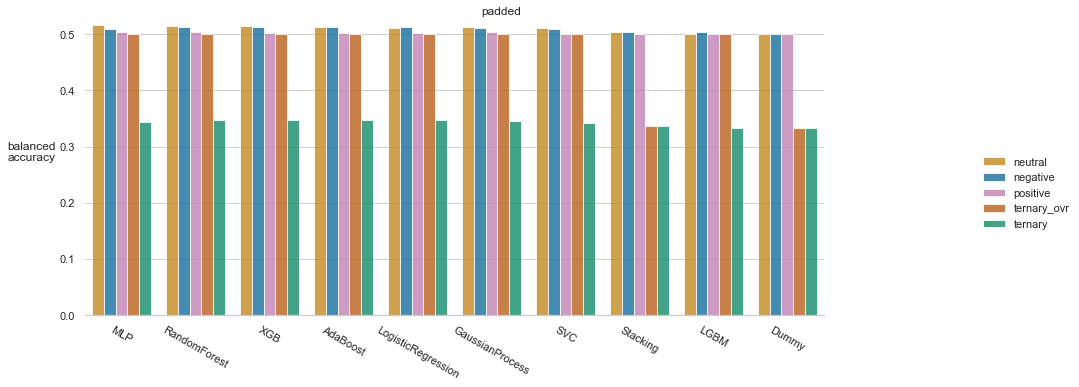

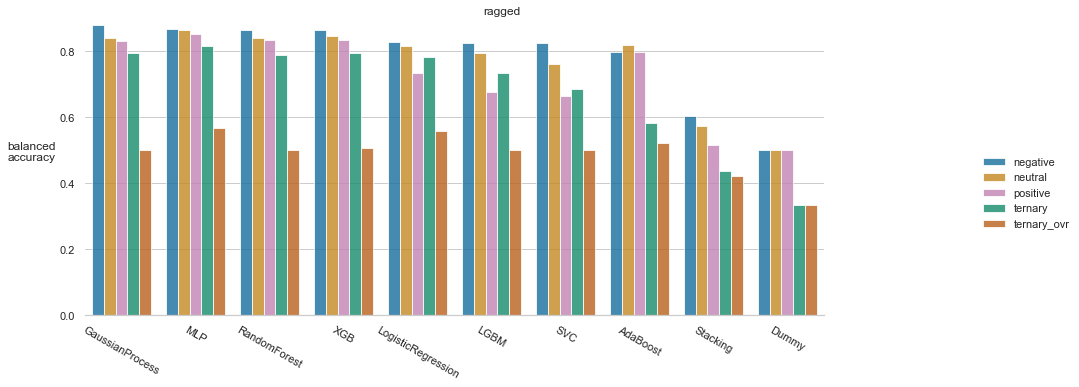

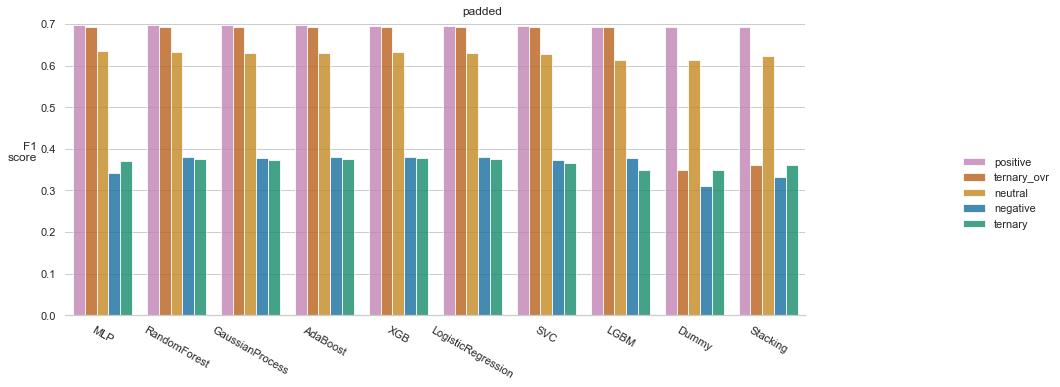

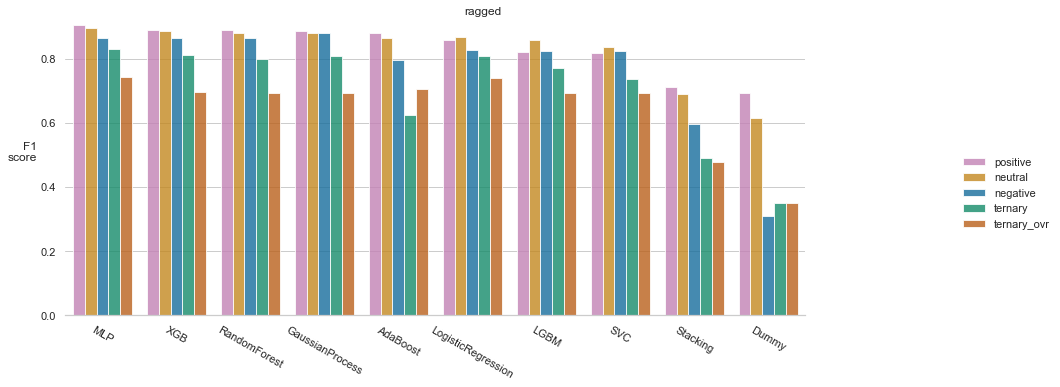

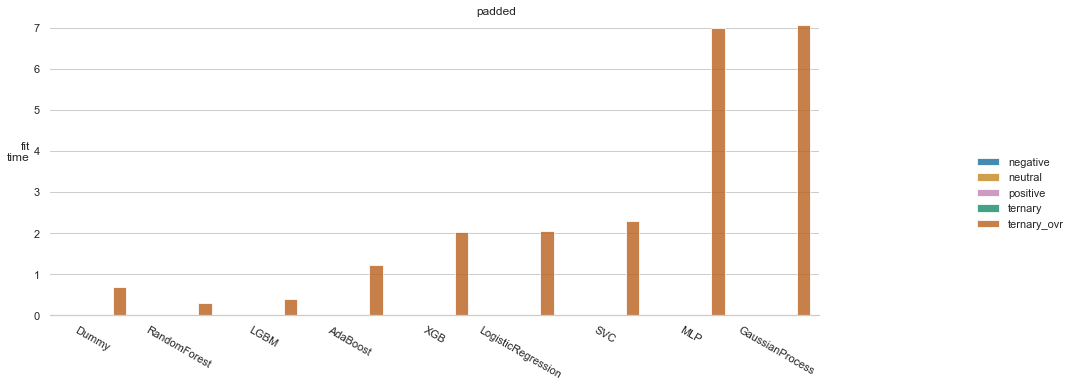

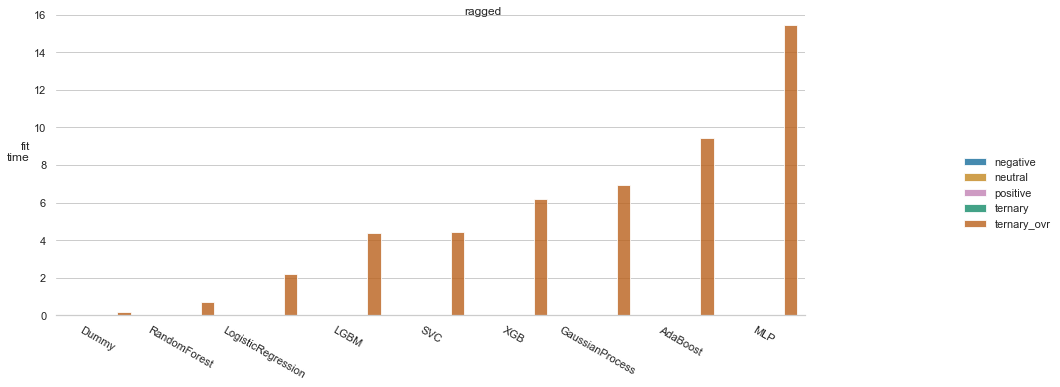

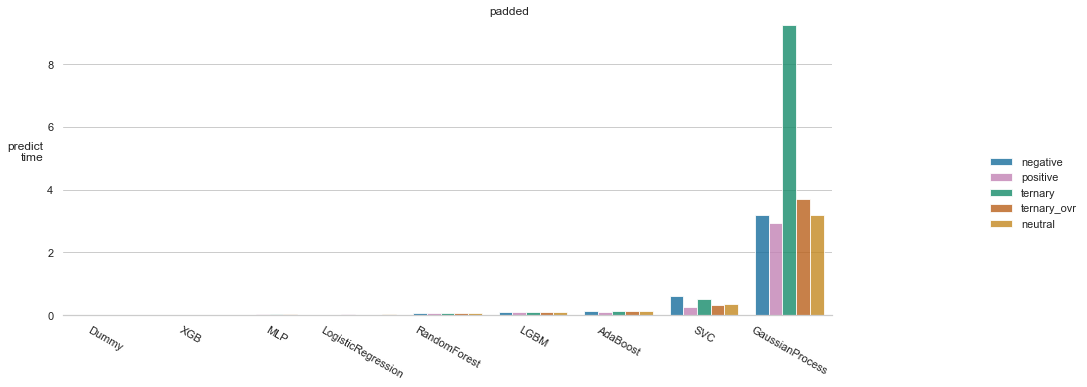

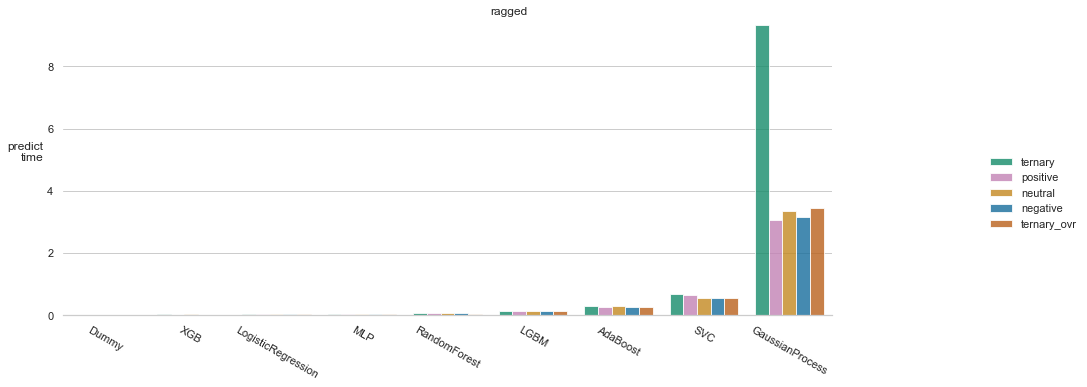

time: 4.89 s


In [47]:
for metric in metrics:
    plot_metric(metric, padded=True)
    plot_metric(metric, padded=False)

In [48]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/shortlong_padrag_results.csv")

time: 8.98 ms


## Discussion

The plots reveal that the ragged FRILL features may perform better than the padded counterpart. This is good news since the final pipeline will be simpler without padding operations.

I was likewise pleased to see that a ternary one-vs-rest approach was outperformed by a direct multinomial ternary approach. The one-vs-rest approach requires three models to be trained irrespective of the underlying algorithm.

I was surprised to see the stacked ensemble perform so poorly. Further investigation is warranted.

Yet, a simple multilayer perceptron, although potentially more costly in training time, is still a contender for the most performant after tuning.

In general, classifiers peformed best in binary classification. This lends credence to the idea of a neutral/non-neutral first pass, classifying only those anticipated as non-neutral as either positive or negative, akin to a two-stage OvR-OvO classification with two estimators rather than three.

[^top](#Contents)